## Motivation

Hao applied his naive SV caller to read-fragment-corrected depth-of-coverage data from hg002. 
Calls that are not present in a truth set for this sample are deemed "false calls". 

The question we would like to answer is: Do motifs exist that are more likely to occur in false SV calls than in random DNA? If the answer is yes, then that is a first indication that sequence-dependent biases in read depth  are driving false calls. If these biases can be corrected prior to SV calling, then one might hope to reduce the number of false calls. 




In [1]:
## Google Colab environment 

# !wget http://hgdownload.soe.ucsc.edu/goldenPath/hg19/chromosomes/chr2.fa.gz
# !gunzip chr2.fa.gz
# # change the chromosome label in the FASTA to match that in Hao's call file
# !sed -ie 's/chr2/2/' chr2.fa
# !wget https://github.com/arq5x/bedtools2/releases/download/v2.28.0/bedtools
# !chmod +x ./bedtools
# !wget http://home.chpc.utah.edu/~u0875014/call.filtered.bed
# !wget http://home.chpc.utah.edu/~u6018199/limo-truth.vcf.gz
# !gunzip limo-truth.vcf.gz

## SV calls from Hao's naive caller

In [1]:
from collections import OrderedDict    
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np 

def calls_to_dataframe(calls):
    chromosomes, starts, ends, sequences = [], [], [], []
    for call in calls: 
        chromosome, start, end, sequence = call.replace('-', '\t').replace(':', '\t').split('\t')
        chromosomes.append(chromosome)
        starts.append(start)
        ends.append(end)
        sequences.append(sequence)

    return pd.DataFrame(OrderedDict([
        ('chromosome', chromosomes),
        ('start', starts),
        ('end', ends),
        ('sequence', sequences)
    ]))    

def path(file): 
    return '../data/motif_enrichment_in_false_SVs/' + file

def get_naive_calls(): 
    call_set = path('call.filtered.bed')
    chr2 = path('chr2.fa')
    calls = !bedtools getfasta -bed $call_set -fi $chr2 -fo /dev/stdout -tab 
    return calls_to_dataframe(calls)

naive_calls = get_naive_calls()
print('number of naive calls: {}'.format(len(naive_calls)))
naive_calls.head()


number of naive calls: 5840


,chromosome,start,end,sequence
0,2,1,10183,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1,2,10890,11120,ggcgcagagaggcgcaccgcgcccgcgcaggcgcagagaggcgcaccgcgcccgcgcaggcgcagagaggcgcaccgcgcccgcgcaggcgcagag...
2,2,133229,133339,aaaattatcctggcatggtggcgtatgcctgtagtcccaaccgcacaggaggcttaggtgggaggatccactgaactcaggaggtggtggatgcag...
3,2,197732,198231,GCCTGTTGACGTGGAGACGCGCGGGGCCTTTTCCCTTCTGTCTGCCTTTCCGGCCTGTTGACGTGGAGACGCGCGGGGCGTTTTCCCTTCTGTCTG...
4,2,198238,198395,TGTCTGCCTTTCCGGCCTGTTGACGTGGAGACGCGCGGGGCCTTTTCCCTTCTGTCTGCCTTTCCGGCCTGTTGACGTGGAGACGCGCGGGGCCTT...


## False calls from naive SV caller

In [2]:
def get_false_naive_calls(): 
    call_set = path('call.filtered.bed')
    false_call_set = path('call.filtered.false.bed')
    truth_set = path('limo-truth.vcf')
    chr2 = path('chr2.fa')
    !bedtools intersect -v -a $call_set -b $truth_set > $false_call_set 
    calls = !bedtools getfasta -bed $false_call_set -fi $chr2 -fo /dev/stdout -tab 
    df = calls_to_dataframe(calls)
    df['length'] = df['sequence'].map(lambda s: len(s))
    return df

false_naive_calls = get_false_naive_calls()
print('number of false naive calls: {}'.format(len(false_naive_calls)))
false_naive_calls.head()


number of false naive calls: 4369


,chromosome,start,end,sequence,length
0,2,1,10183,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,10182
1,2,10890,11120,ggcgcagagaggcgcaccgcgcccgcgcaggcgcagagaggcgcaccgcgcccgcgcaggcgcagagaggcgcaccgcgcccgcgcaggcgcagag...,230
2,2,133229,133339,aaaattatcctggcatggtggcgtatgcctgtagtcccaaccgcacaggaggcttaggtgggaggatccactgaactcaggaggtggtggatgcag...,110
3,2,197732,198231,GCCTGTTGACGTGGAGACGCGCGGGGCCTTTTCCCTTCTGTCTGCCTTTCCGGCCTGTTGACGTGGAGACGCGCGGGGCGTTTTCCCTTCTGTCTG...,499
4,2,198238,198395,TGTCTGCCTTTCCGGCCTGTTGACGTGGAGACGCGCGGGGCCTTTTCCCTTCTGTCTGCCTTTCCGGCCTGTTGACGTGGAGACGCGCGGGGCCTT...,157


## Random sequences

Let's generate sequences with the same length distribution as false naive calls 
but chosen from random positions in the genome:


In [3]:
from Bio import SeqIO

def get_chromosome(fasta_file='../data/motif_enrichment_in_false_SVs/chr2.fa'):
    for record in SeqIO.parse(fasta_file, 'fasta'):
        if record.id != '2': 
            continue
        record.seq = str(record.seq)
        return record

def _add_sequences(df, chromosome):    
    df['sequence'] = [chromosome.seq[s:e] for s, e in zip(df['start'], df['end'])]
    return df

def get_random_sequences(df):        
    sequence_lengths = df['sequence'].map(lambda s: len(s)).values
    
    chromosome = get_chromosome()
    
    # "replace=False" slows down np.random.choice(...) significantly
    starts = np.random.choice(np.arange(0, len(chromosome.seq)-max(sequence_lengths)+1),
                              size=len(sequence_lengths))
    ends = starts + sequence_lengths
    df = pd.DataFrame(OrderedDict([
        ('chromosome', chromosome.id),
        ('start', starts),
        ('end', ends)
    ]))
    return _add_sequences(df, chromosome).sort_values('start')

random_sequences = get_random_sequences(false_naive_calls)
random_sequences.head()

,chromosome,start,end,sequence
1445,2,2059,2209,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1577,2,35139,35301,gcaacctccgcctcccggattcaagtgattctcctgcctcagcctccctagtagctgggattataggtgtccaccacaacgtctggctaatttttg...
724,2,155913,156035,gtcttactaaatgggtgctggctttttgagtttccttaatttgtgtatataatggcctggctatttcactgtacctgggaatccatattcagcaga...
1355,2,223813,223930,CATACAGGACTCTAGGAGCAGATGCTCAACCCCCTCGGAGGAGAAACATCTGGGAAAAACACTGGAGTGGGCTCCCAGAAGGGGAGGCCAGGGTGA...
2696,2,240293,240477,agccactgccccagcctccagctctggagcaacggcacagagatcttgggcagacagagagacaggctgcaagagcagagagctccaaagctctcc...


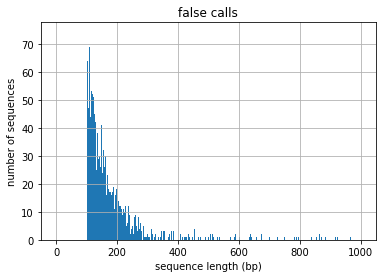

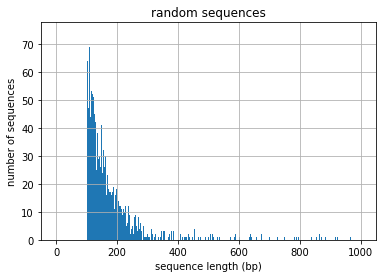

In [50]:
%matplotlib inline 
import matplotlib.pyplot as plt 

variable = { 
    'false calls': false_naive_calls,
    'random sequences': random_sequences
}

def histogram_sequence_lengths(name):
    plt.figure()
    plt.title(name)
    df = variable[name]
    df['sequence'].map(lambda s: len(s)).hist(bins=np.arange(1000))
    plt.xlabel('sequence length (bp)')
    plt.ylabel('number of sequences')

histogram_sequence_lengths('false calls')
histogram_sequence_lengths('random sequences')

## Are false SV calls enriched in certain motifs?

In [57]:
def sequences_containing_motif(df, motif_):
    motif_in_sequence = df['sequence'].map(lambda sequence: motif_.upper() in sequence.upper())
    return df[motif_in_sequence]

def number_of_sequences_containing_motif(df, motif_):
    return len(sequences_containing_motif(df, motif_))

def plot_distribution_of_occurrences(motif_, number_trials=20, number_bins=50):
    background_number_of_motif_occurrences = []
    for i in range(number_trials): 
        background_number_of_motif_occurrences.append(
            number_of_sequences_containing_motif(get_random_sequences(false_naive_calls), motif_)
        )        
    plt.figure()
    plt.title('total number of sequences: {}'.format(len(false_naive_calls)))
    plt.xlabel('number of sequences containing {}'.format(motif_))
    plt.ylabel('number of trials')
    plt.hist(background_number_of_motif_occurrences, bins=np.arange(number_bins), label='random sequences')
    plt.plot([number_of_sequences_containing_motif(false_naive_calls, motif_)]*2, [0, 1], label='false SV calls')
    plt.legend()


## AT repeats

[Ross et al 2013](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2013-14-5-r51) (Table 2), [Smith et al 2015](https://peerj.com/articles/836/) (Fig 3), and we (CEPH data) have established that sequences containing AT dinucleotide repeats tend to have lower read depths than random sequences. This systematic reduction in depth could fool depth-based callers. 

To test this hypothesis, we ask: are AT repeats more (or less) likely to occur in sequences that are called falsely as SVs than random sequences? In the following plots, "number of trials" refers to the number of times that the indicated number of sequences were drawn at random from the chromosome. 


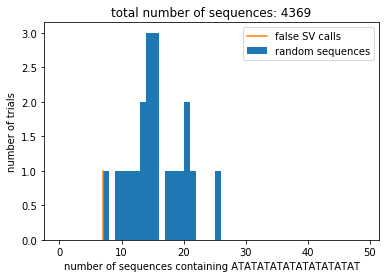

In [25]:
plot_distribution_of_occurrences('AT'*10)

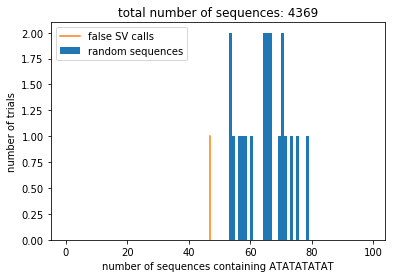

In [31]:
plot_distribution_of_occurrences('AT'*5, number_bins=100)

You can see that AT repeats seem to be slightly under-represented in false SV calls. Don't know how to interpret this. 

## CCCGCC motif 

The CCCGCC motif is also known to reduce read depth: [Ekblom et al 2014](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-15-467) and [Van den Hoecke et al 2016](https://www.nature.com/articles/srep26314). Is this over-represented in false SV calls? 


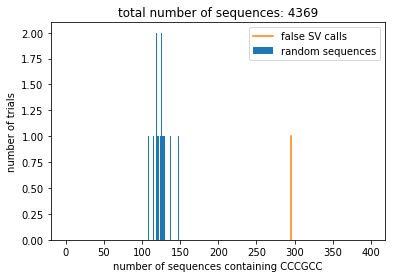

In [44]:
plot_distribution_of_occurrences('CCCGCC', number_bins=400)

CCCGCC appears to be twice as likely to occur in a false SV call as random DNA. This seems promising! 

Here is a dataframe containing false SV calls that harbor CCCGCC: 

In [61]:
sequences_containing_motif(false_naive_calls, 'CCCGCC').head()

,chromosome,start,end,sequence,length
12,2,676327,676441,CAGCAGTCCTCAACCCTCCCCATCCCCTCCTTGAGCGCCCTCCTGCAGAAGACAAGCCCTGCCCTCCAAGCTGCAGCCCCGCCCTGCCCTCCAAGC...,114
25,2,951780,951930,cctgcccctacccctgccctgcccctgcccatgccctgcacccaccgcgccccgcccctgcccctgccctgcacctacccctgccctgcacctacc...,150
52,2,1537275,1537529,CCCCACTGTGTGCAACCTCCCGAAATCCCCCCAACTTTGTGCAACCTCCCCAAATGCCCACTGTGTGCAACGTCCCGAAATCCCCCCCACTCTGTG...,254
54,2,1538899,1539010,CTCTGTGCAACCTCCCCAAATCCCCCCCCCCCCCATTGTGGGCAACCACACCAAATCCCGCCACTTGTGCAACCTCATCAATTTCCCCCCATTCTG...,111
57,2,1540116,1540224,GTCCCGAAATCCCCCCCACTCTGTGCAACCTCCCCAAATCCCCGCCACTCTGTGAAACCTCCCCCATCCCTTCCAGTTTGTGCACCCCCCCAAATC...,108


## To Do 

* use mosdepth to compute the per-base read depth and stick that array into the dataframes, enabling us to: 
    * visually examine the read-depth profile in the false calls 
    * restrict false SV calls to those that exhibit drops in depth that are improbable under a poisson model

* make calls on more samples so that we can restrict false SV calls to those that recur in multiple individuals
